In [2]:
import pandas as pd

# Load datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Explore data
print(customers.info())
print(transactions.info())
print(customers.head())
print(transactions.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TransactionID    1000 non-null   object 
 1   CustomerID       1000 non-null   object 
 2   ProductID        1000 non-null   object 
 3   TransactionDate  1000 non-null   object 
 4   Quantity         1000 non-null   int64  
 5   TotalValue       1000 non-null   float64
 6   Price            1000 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 54.8+ KB
None
  CustomerID

In [3]:
# Aggregate transaction data
transaction_features = transactions.groupby('CustomerID').agg(
    total_spending=('TotalValue', 'sum'),
    purchase_count=('TransactionID', 'count'),
    avg_purchase_value=('TotalValue', 'mean')
).reset_index()

# Merge customer and transaction data
merged_data = pd.merge(customers, transaction_features, on='CustomerID', how='left')

# Handle missing values (if any)
merged_data.fillna(0, inplace=True)

# Normalize numerical features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
numerical_features = ['total_spending', 'purchase_count', 'avg_purchase_value']
merged_data[numerical_features] = scaler.fit_transform(merged_data[numerical_features])

# Encode categorical features (e.g., Region)
merged_data = pd.get_dummies(merged_data, columns=['Region'], drop_first=True)

print(merged_data.head())


  CustomerID        CustomerName  SignupDate  total_spending  purchase_count  \
0      C0001    Lawrence Carroll  2022-07-10       -0.051884        0.000000   
1      C0002      Elizabeth Lutz  2022-02-13       -0.862714       -0.451294   
2      C0003      Michael Rivera  2024-03-07       -0.393842       -0.451294   
3      C0004  Kathleen Rodriguez  2022-10-09        1.035375        1.353881   
4      C0005         Laura Weber  2022-08-15       -0.769499       -0.902587   

   avg_purchase_value  Region_Europe  Region_North America  \
0           -0.054781          False                 False   
1           -0.903985          False                 False   
2           -0.011575          False                 False   
3           -0.061170          False                 False   
4           -0.025086          False                 False   

   Region_South America  
0                  True  
1                 False  
2                  True  
3                  True  
4               

In [4]:
from sklearn.cluster import KMeans

# Define the number of clusters (you can experiment with 2-10)
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
merged_data['Cluster'] = kmeans.fit_predict(merged_data[numerical_features])

print(merged_data['Cluster'].value_counts())


Cluster
1    71
2    44
3    43
0    42
Name: count, dtype: int64


In [5]:
from sklearn.metrics import davies_bouldin_score, silhouette_score

# Calculate DB Index
db_index = davies_bouldin_score(merged_data[numerical_features], merged_data['Cluster'])

# Calculate Silhouette Score
silhouette_avg = silhouette_score(merged_data[numerical_features], merged_data['Cluster'])

print(f"Davies-Bouldin Index: {db_index}")
print(f"Silhouette Score: {silhouette_avg}")


Davies-Bouldin Index: 1.0742466760923444
Silhouette Score: 0.29989395957395887


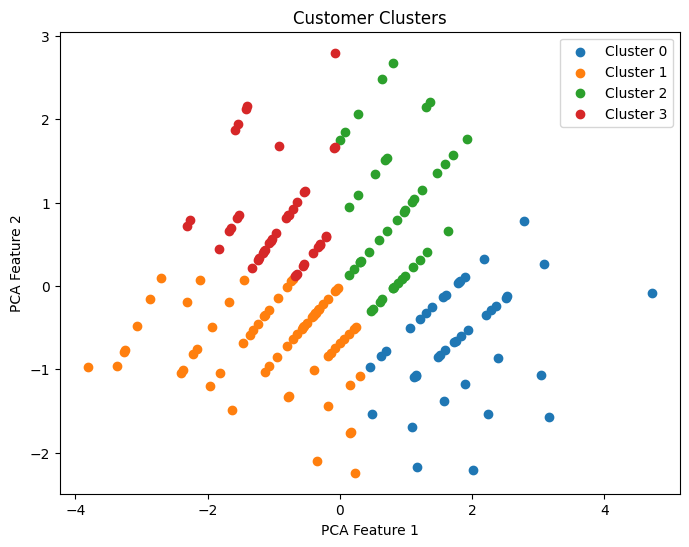

In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 2D for visualization
pca = PCA(n_components=2)
pca_features = pca.fit_transform(merged_data[numerical_features])

# Plot clusters
plt.figure(figsize=(8, 6))
for cluster in range(n_clusters):
    plt.scatter(
        pca_features[merged_data['Cluster'] == cluster, 0],
        pca_features[merged_data['Cluster'] == cluster, 1],
        label=f'Cluster {cluster}'
    )
plt.title('Customer Clusters')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.legend()
plt.show()


In [7]:
# Analyze cluster characteristics
cluster_summary = merged_data.groupby('Cluster').agg(
    avg_spending=('total_spending', 'mean'),
    avg_purchase_count=('purchase_count', 'mean'),
    customer_count=('CustomerID', 'count')
)

print(cluster_summary)


         avg_spending  avg_purchase_count  customer_count
Cluster                                                  
0            1.323341            1.386116              42
1           -0.682046           -0.203400              71
2            0.557022           -0.030770              44
3           -0.736372           -0.986549              43


In [8]:
# Save the final data with clusters
merged_data.to_csv('Clustered_Customers.csv', index=False)
